# Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import Library

In [2]:
import torch
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import numpy as np
from torch import nn
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Load Data

In [3]:
!cp /content/drive/MyDrive/HCMUS/CDTGMT/Project2/256_ObjectCategories.tar /content
!tar -xvf 256_ObjectCategories.tar
%cd /content/256_ObjectCategories

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
256_ObjectCategories/229.tricycle/229_0011.jpg
256_ObjectCategories/229.tricycle/229_0012.jpg
256_ObjectCategories/229.tricycle/229_0013.jpg
256_ObjectCategories/229.tricycle/229_0014.jpg
256_ObjectCategories/229.tricycle/229_0015.jpg
256_ObjectCategories/229.tricycle/229_0016.jpg
256_ObjectCategories/229.tricycle/229_0017.jpg
256_ObjectCategories/229.tricycle/229_0018.jpg
256_ObjectCategories/229.tricycle/229_0019.jpg
256_ObjectCategories/229.tricycle/229_0020.jpg
256_ObjectCategories/229.tricycle/229_0021.jpg
256_ObjectCategories/229.tricycle/229_0022.jpg
256_ObjectCategories/229.tricycle/229_0023.jpg
256_ObjectCategories/229.tricycle/229_0024.jpg
256_ObjectCategories/229.tricycle/229_0025.jpg
256_ObjectCategories/229.tricycle/229_0026.jpg
256_ObjectCategories/229.tricycle/229_0027.jpg
256_ObjectCategories/229.tricycle/229_0028.jpg
256_ObjectCategories/229.tricycle/229_0029.jpg
256_ObjectCategories/229.tricycle/229_0030.jpg
256

In [4]:
for folder in os.listdir("/content/256_ObjectCategories"):
    for file in os.listdir(folder):
        if file.split(".")[-1] != "jpg":
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

In [5]:
import os
filepath = []
y = []
for folder in os.listdir("/content/256_ObjectCategories"):
    for file in os.listdir(folder):
        filepath.append(os.path.join(folder, file))
        y.append(int(folder.split(".")[0]))
print(y)

[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72,

In [6]:
from PIL import Image
image_width, image_height = Image.open(filepath[0]).size
print("Total image: ", len(filepath))
print("Image Dims: ", image_width, "x", image_height)
print("Label counts: ", len(set(y)))

Total image:  30607
Image Dims:  283 x 228
Label counts:  257


# Visualize

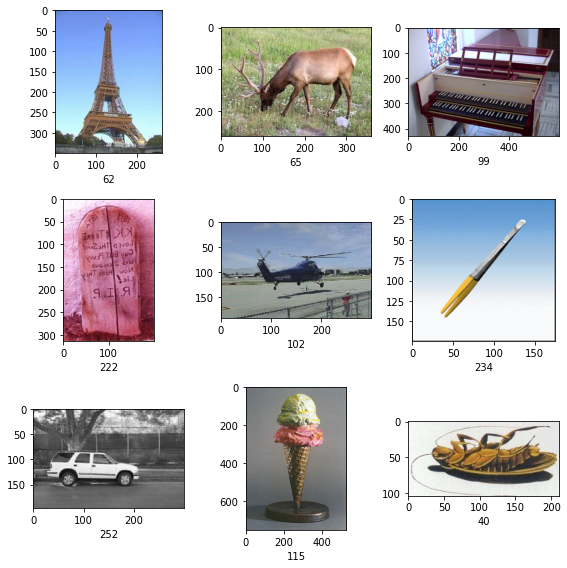

In [7]:
plt.subplots(3,3, figsize=(8,8))
for i, k in enumerate(np.random.randint(len(filepath), size=9)):
    im = Image.open(filepath[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(int(y[k]))
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

# Train-Test Split

In [8]:
train_filepath, test_filepath, y_train, y_test = train_test_split(filepath, y, random_state=1999, test_size=0.1)
train_filepath, val_filepath, y_train, y_val = train_test_split(train_filepath, y_train, random_state=1999, test_size=0.1)

In [9]:
print("Train Size: ", len(train_filepath))
print("Val Size: ", len(val_filepath))
print("Test Size: ", len(test_filepath))

Train Size:  24791
Val Size:  2755
Test Size:  3061


# Dataset Loader

In [10]:
from torchvision import datasets, transforms
class Caltech256Dataset(Dataset):
    def __init__(self, paths, labels, grayscale=True, color_mode='grayscale', target_size=(32, 32), interpolation='nearest'):
        super().__init__()
        self.paths = paths
        self.labels = labels
        self.grayscale = grayscale
        self.color_mode = color_mode
        self.target_size = target_size
        self.interpolation = interpolation
    def __getitem__(self, idx):
        image = tf.keras.utils.load_img(self.paths[idx], grayscale=self.grayscale, 
                        color_mode=self.color_mode, target_size=self.target_size, interpolation=self.interpolation)
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        return np.transpose(np.array([input_arr])[0]), self.labels[idx]
        # return np.array([input_arr])[0], self.labels[idx]
    def __len__(self):
        return len(self.paths)

In [11]:
caltech256_train = Caltech256Dataset(train_filepath, y_train)
train_loader = DataLoader(caltech256_train, batch_size=128, shuffle=True, num_workers=2)
caltech256_validation = Caltech256Dataset(val_filepath, y_val)
val_loader = DataLoader(caltech256_validation, batch_size=128, shuffle=False, num_workers=2)

# Model

In [12]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, num_classes + 1)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
# !pip install efficientnet-pytorch

In [14]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(set(y)))

# Train

In [15]:
def train_one_epoch(model, train_loader, optim, loss, epoch):
    print(f"EPOCH {epoch}:")
    model.train()
    for idx, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optim.zero_grad()
        y_pred = model(X_train.float())
        loss = loss_fn(y_pred, y_train.long())
        if idx % 100 == 0:
            print('idx: {}, loss: {}'.format(idx, loss.sum().item()))
        loss.backward()
        optim.step()

In [16]:
@torch.inference_mode()
def validate_one_epoch(model, val_loader):
    all_correct_num = 0
    all_sample_num = 0
    model.eval()
    for idx, (X_val, y_val) in enumerate(val_loader):
        predict_y = model(X_val.float()).detach()
        predict_y = np.argmax(predict_y, axis=-1)
        current_correct_num = predict_y == y_val
        all_correct_num += np.sum(current_correct_num.numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    return acc

In [17]:
EPOCH = 100
PATIENCE = 0
CHECKPOINT_PATH = "/content"
def run_training(model, train_loader, val_loader, optim, loss, patience):
    best_acc = 0
    for i in range(EPOCH):
        train_one_epoch(model, train_loader, optim, loss, i + 1)
        curr_acc = validate_one_epoch(model, val_loader)
        if curr_acc <= best_acc:
            patience += 1
            print("Not Improve!")
        else:
            best_acc = curr_acc
            print("Val Acc: ", best_acc)
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, "epoch_" + str(i + 1)))
        if patience == 2:
            break
    return model

In [18]:
model = Model(len(set(y)))
sgd = SGD(model.parameters(), lr=1e-1)
loss_fn = CrossEntropyLoss()
model = run_training(model, train_loader=train_loader, val_loader=val_loader, optim=sgd, loss=loss_fn, patience=PATIENCE)

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


  0%|          | 0/194 [00:00<?, ?it/s]

idx: 0, loss: 13.43353271484375
idx: 100, loss: 5.504555702209473


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Val Acc:  0.027586206896551724
EPOCH 2:


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


  0%|          | 0/194 [00:00<?, ?it/s]

idx: 0, loss: 5.559830665588379
idx: 100, loss: 5.29575777053833


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Not Improve!
EPOCH 3:


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


  0%|          | 0/194 [00:00<?, ?it/s]

idx: 0, loss: 5.423194408416748
idx: 100, loss: 5.462089538574219


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Not Improve!
